In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# ========== Load Dataset ==========
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"  # Update folder & filename if different
df = pd.read_csv(file_path)

# ========== Stratified Split (80% Train, 20% Test) ==========
train_df, test_df = train_test_split(df, test_size=0.20, stratify=df["Binary_class"], random_state=42)

# ========== Save Split Data (Kaggle uses `/kaggle/working` for output) ==========
train_df.to_csv("/kaggle/working/train_data.csv", index=False)
test_df.to_csv("/kaggle/working/test_data.csv", index=False)

# ========== Summary Table ==========
split_summary = pd.DataFrame({
    "Train (80%)": train_df["Binary_class"].value_counts(),
    "Test (20%)": test_df["Binary_class"].value_counts(),
    "Total": df["Binary_class"].value_counts()
}).T

# ========== Save Summary Table ==========
split_summary.to_csv("/kaggle/working/split_summary.csv")

# ========== Display ==========
print("\nData Split Summary:\n", split_summary)
print("\n✅ 80-20 Train-Test split completed and saved to `/kaggle/working/`.")



Data Split Summary:
 Binary_class  Non-Damage  Damage
Train (80%)        12403    2062
Test (20%)          3102     515
Total              15505    2577

✅ 80-20 Train-Test split completed and saved to `/kaggle/working/`.


2025-04-26 13:02:57.086423: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745672577.279253      87 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745672577.334945      87 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading FastText model...
[===================-------------------------------] 38.1% 365.1/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
NotebookApp.rate_limit_window=1.0 (secs)



[=============================---------------------] 60.0% 575.0/958.4MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
NotebookApp.rate_limit_window=1.0 (secs)



[=====================================-------------] 75.4% 723.0/958.4MB downloadedGenerating document embeddings...


100%|██████████| 3617/3617 [00:00<00:00, 33206.59it/s]


Before SMOTE - Train: [12403  2062]
After SMOTE - Train: [12403 12403]
Before SMOTE - Test: [3102  515]
After SMOTE - Test: [3102 3102]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745672861.166280      87 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/10


I0000 00:00:1745672864.434985     140 service.cc:148] XLA service 0x7a643000b680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745672864.435423     140 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745672864.718374     140 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745672866.158502     140 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


776/776 - 6s - 8ms/step - accuracy: 0.8281 - loss: 0.3860
Epoch 2/10
776/776 - 1s - 1ms/step - accuracy: 0.8718 - loss: 0.3082
Epoch 3/10
776/776 - 1s - 1ms/step - accuracy: 0.8901 - loss: 0.2671
Epoch 4/10
776/776 - 1s - 1ms/step - accuracy: 0.9041 - loss: 0.2399
Epoch 5/10
776/776 - 1s - 1ms/step - accuracy: 0.9124 - loss: 0.2205
Epoch 6/10
776/776 - 1s - 1ms/step - accuracy: 0.9203 - loss: 0.2023
Epoch 7/10
776/776 - 1s - 1ms/step - accuracy: 0.9286 - loss: 0.1868
Epoch 8/10
776/776 - 1s - 1ms/step - accuracy: 0.9363 - loss: 0.1695
Epoch 9/10
776/776 - 1s - 1ms/step - accuracy: 0.9379 - loss: 0.1624
Epoch 10/10
776/776 - 1s - 1ms/step - accuracy: 0.9414 - loss: 0.1537
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Test Evaluation Summary:
✅ Test Accuracy   : 0.8433
✅ Test ROC-AUC    : 0.9318
✅ Classification Report:
               precision    recall  f1-score   support

  Non-Damage       0.79      0.93      0.86      3102
      Damage       0.

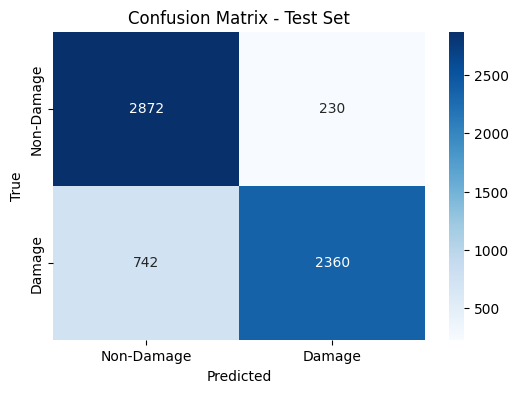

In [2]:
# ========== Imports ==========
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import gensim.downloader as api
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

# ========== Load FastText Model ==========
print("Loading FastText model...")
fasttext_model = api.load("fasttext-wiki-news-subwords-300")
embedding_dim = 300

# ========== Load Dataset ==========
train_df = pd.read_csv("/kaggle/working/train_data.csv")
test_df = pd.read_csv("/kaggle/working/test_data.csv")

# ========== Preprocess Labels ==========
label_map = {'damage': 1, 'non-damage': 0}
train_df['Binary_class'] = train_df['Binary_class'].str.strip().str.lower().map(label_map)
test_df['Binary_class'] = test_df['Binary_class'].str.strip().str.lower().map(label_map)

# ========== Handle Missing Text ==========
train_df['Processed_data'] = train_df['Processed_data'].fillna("")
test_df['Processed_data'] = test_df['Processed_data'].fillna("")

# ========== Function to Create Document Embeddings ==========
def get_avg_embedding(text, model, dim):
    words = text.split()
    embeddings = [model[word] for word in words if word in model]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(dim)

# ========== Generate Embeddings ==========
print("Generating document embeddings...")
X_train = np.vstack([get_avg_embedding(text, fasttext_model, embedding_dim) for text in tqdm(train_df['Processed_data'])])
X_test = np.vstack([get_avg_embedding(text, fasttext_model, embedding_dim) for text in tqdm(test_df['Processed_data'])])

y_train = train_df['Binary_class'].values
y_test = test_df['Binary_class'].values

# ========== Balance with SMOTE (Train & Test) ==========
print("Before SMOTE - Train:", np.bincount(y_train))
smote = SMOTE(random_state=42, sampling_strategy=1.0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("After SMOTE - Train:", np.bincount(y_train_smote))

print("Before SMOTE - Test:", np.bincount(y_test))
X_test_smote, y_test_smote = smote.fit_resample(X_test, y_test)
print("After SMOTE - Test:", np.bincount(y_test_smote))

# ========== Build CNN Model ==========
model = Sequential([
    Dense(256, activation='relu', input_shape=(embedding_dim,)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# ========== Train the Model ==========
history = model.fit(
    X_train_smote, y_train_smote,
    epochs=10,
    batch_size=32,
    verbose=2
)

# ========== Evaluate on SMOTE-applied Test Set ==========
test_loss, test_accuracy = model.evaluate(X_test_smote, y_test_smote, verbose=0)
test_preds = (model.predict(X_test_smote) > 0.5).astype(int)
test_proba = model.predict(X_test_smote)
test_roc_auc = roc_auc_score(y_test_smote, test_proba)
test_report = classification_report(y_test_smote, test_preds, target_names=['Non-Damage', 'Damage'])

print("\n📊 Test Evaluation Summary:")
print(f"✅ Test Accuracy   : {test_accuracy:.4f}")
print(f"✅ Test ROC-AUC    : {test_roc_auc:.4f}")
print("✅ Classification Report:\n", test_report)

# ========== Confusion Matrix ==========
cm = confusion_matrix(y_test_smote, test_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Damage', 'Damage'],
            yticklabels=['Non-Damage', 'Damage'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.show()
